# xgboost

In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import optuna
import warnings
from tqdm import tqdm
warnings.simplefilter('ignore')

In [2]:
# 設定値
class CFG:
    # 変更するパラメータ
    n_folds = 5 # 公差検証の分割数
    n_trials = 100 # ハイパーパラメータチューニングの試行回数
    # その他設定値
    learning_rate = 0.01
    seed = 1234 

In [3]:
# BASE_DIR = '/kaggle/input/icr-identify-age-related-conditions/'
BASE_DIR = '../../data'
train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
greeks_df = pd.read_csv(f'{BASE_DIR}/greeks.csv')
test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
submission_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')

In [4]:
train_df = train_df.drop('EJ', axis=1)
X_train = train_df.drop(['Id', 'Class'], axis=1)
y_train = train_df['Class']

### balanced loglossの計算（学習で使う？）

In [5]:
# 評価基準
def balanced_log_loss(y_true, y_pred):
    N = len(y_true)

    # Nc is the number of observations
    N_1 = np.sum(y_true == 1, axis=0)
    N_0 = np.sum(y_true == 0, axis=0)

    # In order to avoid the extremes of the log function, each predicted probability 𝑝 is replaced with max(min(𝑝,1−10−15),10−15)
    y_pred = np.maximum(np.minimum(y_pred, 1 - 1e-15), 1e-15)

    # balanced logarithmic loss
    loss_numerator = - (1/N_0) * np.sum((1 - y_true) * np.log(1-y_pred)) - (1/N_1) * np.sum(y_true * np.log(y_pred))

    return loss_numerator / 2

# Classの０，１の割合をそれぞれ計算
def calc_log_loss_weight(y_true):
    nc = np.bincount(y_true)
    w0, w1 = 1/(nc[0]/y_true.shape[0]), 1/(nc[1]/y_true.shape[0])
    return w0, w1

In [6]:
# xgboost設定値
xgb_params = {
    'objective': 'binary:logistic',# 学習タスク
    'tree_method': 'gpu_hist',
    'eval_metric': 'rmse',
    'random_state': CFG.seed,
    'learning_rate': CFG.learning_rate,
    # 探索したパラメータ
    'max_depth': 20,
    'colsample_bytree': 0.6597946356014663,
    'subsample': 0.7,
    'gamma': 1.884172979513442,
    'lambda': 0.006050024963423825,
    'min_child_weight': 9,
}
num_boost_round = 926
early_stopping_rounds = 98

In [10]:
scores = []
# K-分割交差検証(層化抽出法)
kfold = StratifiedKFold(n_splits = CFG.n_folds, shuffle = True, random_state = CFG.seed)

for fold, (train_index, valid_index) in enumerate(kfold.split(X_train, y_train)):
    # 進行状況
    print('fold: {}'.format(fold+1))
    # 訓練データを分割
    X_train_fold = X_train.iloc[train_index]
    y_train_fold = y_train.iloc[train_index]
    X_valid_fold = X_train.iloc[valid_index]
    y_valid_fold = y_train.iloc[valid_index]

    # 訓練データの重みを計算
    train_w0, train_w1 = calc_log_loss_weight(y_train_fold)
    # 検証データの重みを計算
    valid_w0, valid_w1 = calc_log_loss_weight(y_valid_fold)
    # 訓練データをxgb用に変換
    xgb_train = xgb.DMatrix(data=X_train_fold, label=y_train_fold, weight=y_train_fold.map({0: train_w0, 1: train_w1}))
    # 検証データをxgb用に変換
    xgb_valid = xgb.DMatrix(data=X_valid_fold, label=y_valid_fold, weight=y_valid_fold.map({0: valid_w0, 1: valid_w1}))

    # モデルのインスタンス生成
    model = xgb.train(
        xgb_params, 
        dtrain = xgb_train, 
        num_boost_round = num_boost_round,
        evals = [(xgb_train, 'train'), (xgb_valid, 'eval')], 
        early_stopping_rounds = early_stopping_rounds,
        verbose_eval = False, # 整数に設定すると、n回ごとのブースティングステージで評価メトリクスを表示
    )
    # 予測
    preds = model.predict(xgb.DMatrix(X_valid_fold), iteration_range=(0, model.best_ntree_limit))
    # 予測値をラベルに変換
    # pred_labels = np.rint(preds)
    # 評価
    # val_score = balanced_log_loss(y_valid, pred_labels)
    val_score = balanced_log_loss(y_valid_fold, preds)

    scores.append(val_score)
# クロスバリデーションの平均値を計算
mean_score = np.mean(scores)
mean_score

fold: 1
fold: 2
fold: 3
fold: 4
fold: 5


0.28495961062567476

### 特徴量重要度を確認

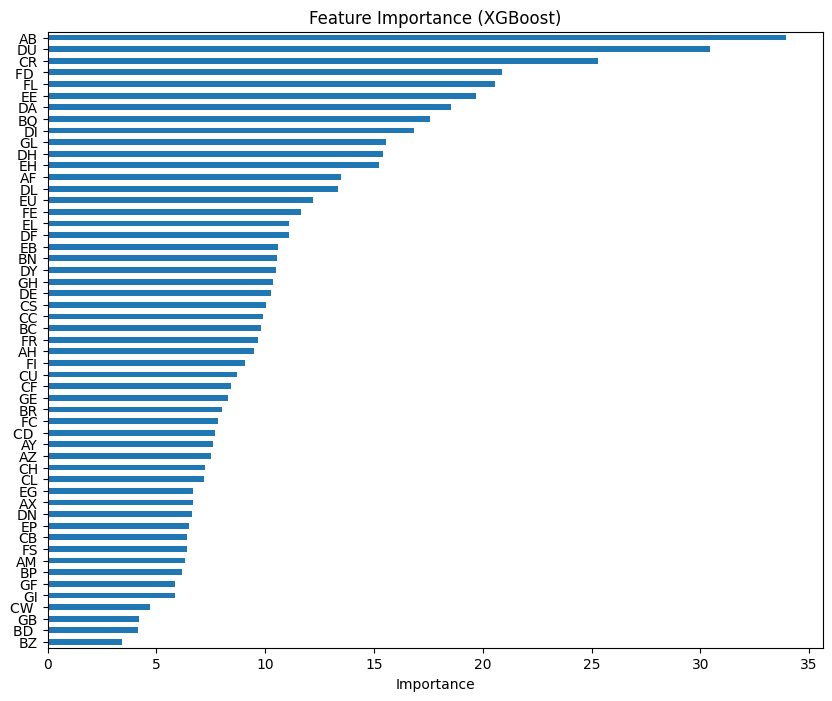

In [27]:
# 特徴量重要度をpandas.Seriesに格納
importances = pd.Series(model.get_score(importance_type='gain')).sort_values(ascending=True)

# 棒グラフを出力
plt.figure(figsize=(10,8))
importances.plot(kind='barh')
plt.title('Feature Importance (XGBoost)')
plt.xlabel('Importance')
plt.show()

### DVとARは使われなかった

In [45]:
# リストを集合に変換
set1 = set(X_train.columns.tolist())
set2 = set(importances.index.tolist())

# 集合の差分を計算
unique_to_list1 = set1 - set2  # list1にのみ存在する要素
unique_to_list2 = set2 - set1  # list2にのみ存在する要素

# 共通でない要素のリスト
list(unique_to_list1) + list(unique_to_list2)

['DV', 'AR']